## HW Week 11 (#9) - Data fitting with various functions - Due Friday Nov 4, 2022


Dowload the data "miniDR17.fits" from the TCU Online Week 11:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but check!!!!</b>). 



In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return a*(x**3)+ (b*(x**2))+ (c*x)+d


def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1]): #for linear fits
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]): #for 3 parameter fit for poly 
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]): #for cosfit
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISTIS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

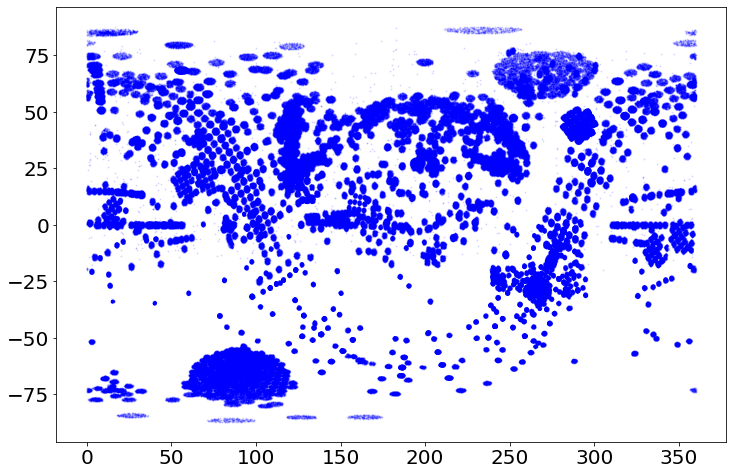

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.630
COSFIT: 72.944, 0.018, -0.452, -5.698


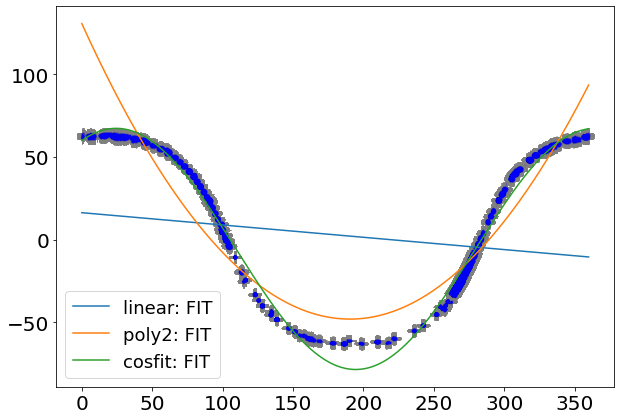

In [4]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS (e.g., −2 < GLAT < 2 )
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 2) & (star['GLAT'] > -2)
cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                          star['RA'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                         star['RA'][cut1]/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                            star['RA'][cut1]/1000,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(star['RA'][cut1]/1000),
             yerr=(star['DEC'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='poly2: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='cosfit: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

## YOUR WORK

Fit  a linear and a polynomial (ploy2 and poly3) functions and to the following selections of the data:
1. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
2. Select stars only with with $-2< GLAT < 2$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>

For each of the above selections:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

LINEAR: -0.182, 0.060
POLY2: -0.042, -0.228, 0.057
COSFIT: 0.141, 0.000, -1.007, 0.142


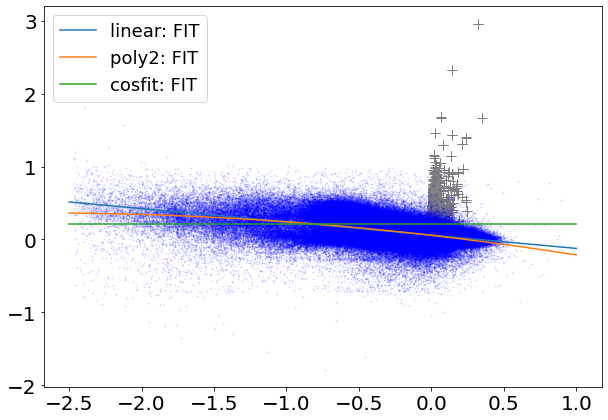

In [13]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

star = star[~np.isnan(star['FE_H'])]
star = star[~np.isnan(star['O_FE'])]
star = star[~np.isnan(star['FE_H_ERR'])]
star = star[~np.isnan(star['O_FE_ERR'])]
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS (e.g., −2 < GLAT < 2 )
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < -10) | (star['GLAT'] > 10) 

cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], p0=[0,0])

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1],p0=[0,0,0])

print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['Fe_H'][cut1], star['O_FE'][cut1],p0=[0,0,0,0])

print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H_ERR'][cut1]),star['O_FE_ERR'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='poly2: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='cosfit: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

LINEAR: -0.120, 0.045
POLY2: -0.015, -0.129, 0.046
COSFIT: 0.330, 0.000, 0.000, -0.271


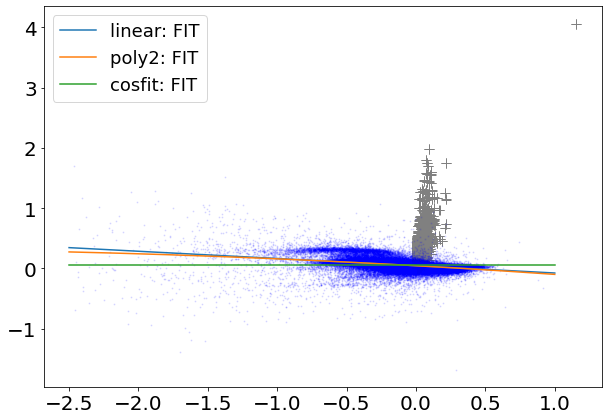

In [12]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

star = star[~np.isnan(star['FE_H'])]
star = star[~np.isnan(star['O_FE'])]
star = star[~np.isnan(star['FE_H_ERR'])]
star = star[~np.isnan(star['O_FE_ERR'])]
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS (e.g., −2 < GLAT < 2 )
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 2) & (star['GLAT'] > -2) 

cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], p0=[0,0])

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1],p0=[0,0,0])

print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['Fe_H'][cut1], star['O_FE'][cut1],p0=[0,0,0,0])

print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H_ERR'][cut1]),star['O_FE_ERR'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000) # X-PLOTING FOR FITS
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='poly2: FIT')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='cosfit: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()